In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

假设有一对样本的特征向量 $\mathbf{x}_1, \mathbf{x}_2$ ，标签 $y \in\{0,1\}$ 表示是否相似（1相似，0不相似），距离计算用欧氏距离：

$$
D=\left\|\mathbf{x}_1-\mathbf{x}_2\right\|_2=\sqrt{\sum_{i=1}^d\left(x_{1 i}-x_{2 i}\right)^2}
$$


损失函数：

$$
L=\frac{1}{2} y D^2+\frac{1}{2}(1-y) \max (0, m-D)^2
$$

- $m>0$ 是 margin，代表＂不相似＂样本之间的最小距离阈值
- 对相似样本，最小化距离平方
- 对不相似样本，惩罚距离小于 margin 的情况

In [2]:
# PyTorch 没有内置 ContrastiveLoss，需要自己实现
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, x1, x2, y):
        # 计算欧氏距离
        dist = torch.nn.functional.pairwise_distance(x1, x2, p=2)
        # 计算loss
        loss_sim = y * dist.pow(2)
        loss_dissim = (1 - y) * torch.clamp(self.margin - dist, min=0).pow(2)
        loss = 0.5 * (loss_sim + loss_dissim)
        return loss.mean()


In [3]:
loss_fn = ContrastiveLoss(margin=1.0)

# batch_size=3, embedding_dim=5
x1 = torch.tensor([
    [1., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0.],
    [1., 1., 0., 0., 0.]
])
x2 = torch.tensor([
    [1., 0., 0., 0., 0.],  # 相似
    [1., 0., 0., 0., 0.],  # 不相似
    [0., 1., 0., 0., 0.]   # 不相似
])

y = torch.tensor([1, 0, 0], dtype=torch.float)

loss = loss_fn(x1, x2, y)
print("ContrastiveLoss:", loss.item())


ContrastiveLoss: 8.333333480735339e-13


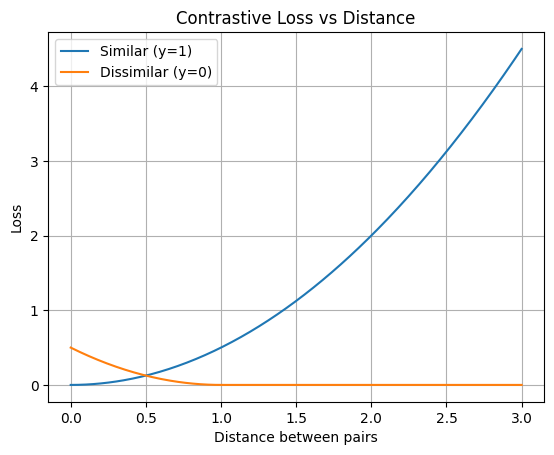

In [4]:
import numpy as np

d = torch.linspace(0, 3, 300)
margin = 1.0

loss_sim = 0.5 * d**2
loss_dissim = 0.5 * torch.clamp(margin - d, min=0)**2

plt.plot(d.numpy(), loss_sim.numpy(), label="Similar (y=1)")
plt.plot(d.numpy(), loss_dissim.numpy(), label="Dissimilar (y=0)")
plt.title("Contrastive Loss vs Distance")
plt.xlabel("Distance between pairs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()
